In [1]:
import pandas as pd
import requests
import os
import json
import numpy as np

## Gather

#### Data number 1: WeRateDogs Twitter archive

In [2]:
rate = pd.read_csv('twitter-archive-enhanced.csv')

#### Data number 2: Tweet image predictions 

In [3]:
folder_name = 'Twitter archive'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [4]:
with open(os.path.join(folder_name, 
                       url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

In [5]:
os.listdir(folder_name)

['image-predictions.tsv']

In [6]:
predict = pd.read_csv(os.path.join(folder_name, 'image-predictions.tsv'), sep='\t')
predict.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Data number 3: Tweeter API

Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file.

In [7]:
import tweepy 

In [11]:
# read this .txt file line by line into a pandas DataFrame with (at minimum) 
#tweet ID, retweet count, and favourite count

columns = ['id', 'retweet_count', 'favorite_count']

In [12]:
tweets = pd.DataFrame(columns = columns)

In [13]:
with open('tweet_json.txt') as tweet_json_file:
    for line in tweet_json_file:
        tweet = json.loads(line)
        d_for_df = {k: tweet[k] for k in columns}
        df_from_d = pd.DataFrame(d_for_df.items())
        tweets = tweets.append(d_for_df, ignore_index=True)

In [14]:
print(tweet.keys())

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang'])


In [15]:
tweets.head()

,id,retweet_count,favorite_count
0,892420643555336193,7587,35825
1,892177421306343426,5623,30929
2,891815181378084864,3720,23282
3,891689557279858688,7766,39105
4,891327558926688256,8362,37353


In [18]:
tweets = tweets.rename({'favorite_count': 'favourite_count'}, axis='columns')

## Assess

##### Tidiness: structural
- the 4 stage names in `rate` table should be turned into values, instead of as column headers. 
- all three tables share the same column tweet_id, so they can be combined to one master pandas DataFrame if necessary. 

##### Quality: missing, duplicates, incorrectness, corrupted (cannot be opened)
###### `rate` table: 
- completeness: since only original ratings are wanted for this analysis, the 181 entries from retweets and 78 from replies would be redundant. These rows can be identified by non-null values in `retweet_status_id` and `in_reply_to_status_id`. 
- `timestamp` column is an object instead of data time datatype. 
- `tweet_id` are integers instead of object (strings). 

######  `predict` table: 
- some columns should be categorical data type, for example `p1`, `p2`, `p3` seemed to be composed of dog breeds names. 
- `tweet_id` are integers instead of object (strings). 
- consistency and accuracy: inconsistent upper and lower cases in `p1`, `p2`, `p3` columns.
- accuracy: `rating_denominator`, `rating_numerator` were extracted from the text column, but not all of them are accurate.  
- validity/accuracy: `p1`, `p2` and `p3` contain a lot of non-valid names that are actually not dog breed names. 

######  `tweets` table: 
- completeness: tweets data (2331 entries) was generated using a list of tweet IDs from the rate table (2356 entries), but since some tweets have been deleted, this data frame has missing values while matching rate. But this problem was solved after combining all three tables into one.
- `favourite_count` and `retweet_count` are objects instead of integers. 

##### Quality issues identified but not cleaned in this project:
- accuracy: `dog name`, and `stage` were extracted from the text column, but not all of them are accurate.  
- validaty: max values for `rating_denominator` (170.0) and `rating_numerator` (1776.0) are outliers since 75% of the data are below 10 and 12 respectively. 

In [19]:
rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [20]:
rate.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [21]:
rate.rating_denominator.sort_values()

313       0
2335      2
516       7
1576     10
1575     10
       ... 
1635    110
1779    120
1634    130
902     150
1120    170
Name: rating_denominator, Length: 2356, dtype: int64

In [22]:
rate.rating_numerator.sort_values()

315        0
1016       0
2335       1
2261       1
2338       1
        ... 
2074     420
188      420
189      666
313      960
979     1776
Name: rating_numerator, Length: 2356, dtype: int64

In [23]:
sum(rate['tweet_id'].duplicated())

0

In [24]:
rate.get(['rating_numerator', 'rating_denominator'])

,rating_numerator,rating_denominator
0,13,10
1,13,10
2,12,10
3,13,10
4,12,10
...,...,...
2351,5,10
2352,6,10
2353,9,10
2354,7,10


In [25]:
# completeness issue
sum(rate['retweeted_status_id'].isnull())

2175

In [26]:
predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [27]:
predict[predict.tweet_id.duplicated()].count()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [28]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               2331 non-null   object
 1   retweet_count    2331 non-null   object
 2   favourite_count  2331 non-null   object
dtypes: object(3)
memory usage: 54.8+ KB


In [29]:
tweets.describe()

,id,retweet_count,favourite_count
count,2331,2331,2331
unique,2331,1688,2004
top,667495797102141441,221,0
freq,1,5,163


In [30]:
rate.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [31]:
rate.text[2]

'This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB'

In [32]:
predict.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [33]:
tweets.head()

,id,retweet_count,favourite_count
0,892420643555336193,7587,35825
1,892177421306343426,5623,30929
2,891815181378084864,3720,23282
3,891689557279858688,7766,39105
4,891327558926688256,8362,37353


## Clean

In [34]:
# making copies of original data sets
rate_clean = rate.copy()
predict_clean = predict.copy()
tweets_clean = tweets.copy()

Tidiness programmatic assessment

In [35]:
all_columns = pd.Series(list(rate) + list(predict) + list(tweets))
all_columns[all_columns.duplicated()]

17    tweet_id
dtype: object

### Define: Tidiness
- the 4 stage names in `rate` table should be turned into values, instead of as column headers. 

In [36]:
rate_clean.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
970,750117059602808832,NaN,NaN,2016-07-05 00:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Calvin. He just loves America so much....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750117059...,10,10,Calvin,None,None,None,None


### Code

In [37]:
# set dog stages with "None" as value to nan
rate_clean.doggo.replace('None', '', inplace=True)
rate_clean.floofer.replace('None', '', inplace=True)
rate_clean.pupper.replace('None', '', inplace=True)
rate_clean.puppo.replace('None', '', inplace=True)

In [38]:
rate_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,,,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,,,
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,,,
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,,,
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,,,


In [39]:
# Concatenate all 4 columns to 1 column dog_stage
rate_clean['stage'] = rate_clean.doggo + rate_clean.floofer + rate_clean.pupper + rate_clean.puppo

### Test

In [40]:
rate_clean.stage.value_counts()

                1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggofloofer       1
doggopuppo         1
Name: stage, dtype: int64

In [41]:
rate_clean[rate_clean.index==1845]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage
1845,675845657354215424,NaN,NaN,2015-12-13 01:12:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pepper. She's not fully comfortable ri...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675845657...,10,10,Pepper,,,pupper,,pupper


In [42]:
#index 1995, 1628, 1845

In [43]:
rate_clean.loc[rate_clean.stage=='doggopupper', 'stage']='doggo, pupper'
rate_clean.loc[rate_clean.stage=='doggopuppo', 'stage']='doggo, puppo'
rate_clean.loc[rate_clean.stage=='doggofloofer', 'stage']='doggo, floofer'

In [44]:
rate_clean.drop(['doggo', 'puppo', 'pupper', 'floofer'], axis=1, inplace=True)

In [45]:
rate_clean.info()
rate_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  stage                       2356 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,


### Define: tidiness
- all three tables share the same column tweet_id, so they can be concatanated to one master pandas DataFrame if neccessary. 

### Code

In [46]:
# combining three tables into one master DataFrame
rate_predict = pd.merge(rate_clean, predict_clean, on='tweet_id')

In [47]:
df = pd.merge(rate_predict, tweets, left_on='tweet_id', right_on='id')

### Test

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2059 non-null   object 
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2059 non-null   object 
 4   source                      2059 non-null   object 
 5   text                        2059 non-null   object 
 6   retweeted_status_id         72 non-null     float64
 7   retweeted_status_user_id    72 non-null     float64
 8   retweeted_status_timestamp  72 non-null     object 
 9   expanded_urls               2059 non-null   object 
 10  rating_numerator            2059 non-null   int64  
 11  rating_denominator          2059 non-null   int64  
 12  name                        2059 non-null   object 
 13  stage                       2059 

### Define: completeness (missing, duplicate, and irrelevant data)

1. since only original ratings are wanted for this analysis, the 181 (became 72 after tables being merged) entries from retweets and 78 (became 23 after tables being merged) from replies would be redundant. These rows can be identified by non-null values in `retweet_status_id` and `in_reply_to_status_id`. 
2. empty columns that are not needed for later stage can be cleaned up (e.g. `retweeted_status_id` etc.). 

### Code

In [49]:
index_retweets = df[df['retweeted_status_timestamp'].notna()].index
index_replies = df[df['in_reply_to_status_id'].notna()].index

In [50]:
df.drop(index_retweets, inplace=True)
df.drop(index_replies, inplace=True)

### Test

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2058
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1964 non-null   object 
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   1964 non-null   object 
 4   source                      1964 non-null   object 
 5   text                        1964 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1964 non-null   object 
 10  rating_numerator            1964 non-null   int64  
 11  rating_denominator          1964 non-null   int64  
 12  name                        1964 non-null   object 
 13  stage                       1964 

Drop empty columns: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`. <br>
Drop duplicated column: `id`


In [52]:
df.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'id'], axis=1, inplace=True)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2058
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1964 non-null   object 
 1   timestamp           1964 non-null   object 
 2   source              1964 non-null   object 
 3   text                1964 non-null   object 
 4   expanded_urls       1964 non-null   object 
 5   rating_numerator    1964 non-null   int64  
 6   rating_denominator  1964 non-null   int64  
 7   name                1964 non-null   object 
 8   stage               1964 non-null   object 
 9   jpg_url             1964 non-null   object 
 10  img_num             1964 non-null   int64  
 11  p1                  1964 non-null   object 
 12  p1_conf             1964 non-null   float64
 13  p1_dog              1964 non-null   bool   
 14  p2                  1964 non-null   object 
 15  p2_conf             1964 non-null   float64
 16  p2_dog

### Define: Data types

3. `favourite_count` and `retweet_count` should be converted into integers.
4. `tweet_id` should be converted into object (strings). 
5. `timestamp` should be converted into data time datatype. 
6. `stage` should be turned into categorical data type. 

### Code

In [54]:
# converting retweet_count and favourite_count columns into integers

df['retweet_count'] = pd.to_numeric(df.retweet_count)
df['favourite_count'] = pd.to_numeric(df.favourite_count)

In [55]:
# converting tweet_id column into string

df['tweet_id'] = df.tweet_id.astype(str)

In [56]:
# converting timestamp into data time data type

df['timestamp'] = pd.to_datetime(df.timestamp)

In [57]:
# converting stage column as categorical data

df['stage'] = df.stage.astype('category')

### Test

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2058
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1964 non-null   object             
 1   timestamp           1964 non-null   datetime64[ns, UTC]
 2   source              1964 non-null   object             
 3   text                1964 non-null   object             
 4   expanded_urls       1964 non-null   object             
 5   rating_numerator    1964 non-null   int64              
 6   rating_denominator  1964 non-null   int64              
 7   name                1964 non-null   object             
 8   stage               1964 non-null   category           
 9   jpg_url             1964 non-null   object             
 10  img_num             1964 non-null   int64              
 11  p1                  1964 non-null   object             
 12  p1_conf             1964 non-null 

### Define: consistency 

7. Inconsistent upper and lower cases in breed names.

### Code

In [59]:
df['p1'] = df.p1.astype(str)
df['p2'] = df.p2.astype(str)
df['p3'] = df.p3.astype(str)

df.p1 = df.p1.str.lower()
df.p2 = df.p2.str.lower()
df.p3 = df.p3.str.lower()

### Test

In [60]:
df[['p1', 'p2', 'p3']]

,p1,p2,p3
0,orange,bagel,banana
1,chihuahua,pekinese,papillon
2,chihuahua,malamute,kelpie
3,paper_towel,labrador_retriever,spatula
4,basset,english_springer,german_short-haired_pointer
...,...,...,...
2054,miniature_pinscher,rottweiler,doberman
2055,rhodesian_ridgeback,redbone,miniature_pinscher
2056,german_shepherd,malinois,bloodhound
2057,redbone,miniature_pinscher,rhodesian_ridgeback


### Define

8. Some rating denominators and numerators are extracted incorrectly, which should be improved. 
9. Completeness: `rating` column can be added using `rating_numerator` and `rating_denominator`. 

### Code

In [61]:
# extracting the correct numerators and denominators

correct_rating = df.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)

In [62]:
df['numerator'] = pd.to_numeric(correct_rating[0])
df['denominator'] = pd.to_numeric(correct_rating[1])

In [63]:
df.drop(['rating_numerator', 'rating_denominator'], axis=1, inplace=True)

In [64]:
df['rating'] = df['numerator'] / df['denominator']

### Test

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2058
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   tweet_id         1964 non-null   object             
 1   timestamp        1964 non-null   datetime64[ns, UTC]
 2   source           1964 non-null   object             
 3   text             1964 non-null   object             
 4   expanded_urls    1964 non-null   object             
 5   name             1964 non-null   object             
 6   stage            1964 non-null   category           
 7   jpg_url          1964 non-null   object             
 8   img_num          1964 non-null   int64              
 9   p1               1964 non-null   object             
 10  p1_conf          1964 non-null   float64            
 11  p1_dog           1964 non-null   bool               
 12  p2               1964 non-null   object             
 13  p2_conf          1

In [66]:
df.describe()

,img_num,p1_conf,p2_conf,p3_conf,retweet_count,favourite_count,numerator,denominator,rating
count,1964.000000,1964.000000,1.964000e+03,1.964000e+03,1964.000000,1964.000000,1964.000000,1964.000000,1964.000000
mean,1.202138,0.593928,1.346393e-01,6.028936e-02,2437.735234,8236.477597,12.178605,10.479124,1.164848
std,0.559615,0.272134,1.009430e-01,5.096697e-02,4354.935394,12110.404097,41.681303,6.865424,4.095124
min,1.000000,0.044333,1.011300e-08,1.740170e-10,11.000000,70.000000,0.000000,2.000000,0.000000
25%,1.000000,0.362775,5.352722e-02,1.619708e-02,542.500000,1768.250000,10.000000,10.000000,1.000000
50%,1.000000,0.587357,1.173995e-01,4.947920e-02,1178.000000,3720.000000,11.000000,10.000000,1.100000
75%,1.000000,0.847062,1.955618e-01,9.162278e-02,2785.250000,10274.500000,12.000000,10.000000,1.200000
max,4.000000,1.000000,4.880140e-01,2.734190e-01,76662.000000,154398.000000,1776.000000,170.000000,177.600000


### Define
10. Filter out predictions that are not dog breed names

### Code

In [67]:
non_breed_list = ['cardigan', 'long-horned_beetle', 'cliff', 'wooden_spoon', 'syringe', 'tricycle', 'mortarboard', 'marmot', 'padlock', 'angora', 'pole', 'gondola', 'limousine', 'pillow', 'grille', 'web_site', 'cowboy_boot', 'flat-coated_retriever', 'gas_pump', 'dough', 'cash_machine', 'teapot', 'washer', 'convertible', 'cash_machine', 'laptop', 'fountain', 'conch', 'conch', 'arabian_camel', 'bubble', 'orange', 'beaver', 'prison', 'revolver', 'barbell', 'basketball', 'upright', 'quilt', 'remote_control', 'swing', 'nail', 'suit', 'microphone', 'home_theater', 'hippopotamus', 'paper_towel', 'school_bus', 'comic_book']

In [68]:
p1_breeds = pd.DataFrame(df.p1.value_counts())

In [69]:
p1_breeds.columns = ['breeds']
breed_list = p1_breeds.index
print(breed_list)

Index(['golden_retriever', 'labrador_retriever', 'pembroke', 'chihuahua',
       'pug', 'chow', 'samoyed', 'pomeranian', 'toy_poodle', 'malamute',
       ...
       'four-poster', 'bison', 'african_grey', 'laptop', 'swab', 'leaf_beetle',
       'pool_table', 'rapeseed', 'coil', 'groenendael'],
      dtype='object', length=373)


In [70]:
for breed in non_breed_list:
    index_names = df[df['p1']==breed].index
    df.drop(index_names, inplace=True)    

### Test

In [71]:
df.p1.value_counts()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1861 entries, 1 to 2058
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   tweet_id         1861 non-null   object             
 1   timestamp        1861 non-null   datetime64[ns, UTC]
 2   source           1861 non-null   object             
 3   text             1861 non-null   object             
 4   expanded_urls    1861 non-null   object             
 5   name             1861 non-null   object             
 6   stage            1861 non-null   category           
 7   jpg_url          1861 non-null   object             
 8   img_num          1861 non-null   int64              
 9   p1               1861 non-null   object             
 10  p1_conf          1861 non-null   float64            
 11  p1_dog           1861 non-null   bool               
 12  p2               1861 non-null   object             
 13  p2_conf          1

## Storing, Analyzing, and Visualizing Data 

*Notes:* If additional files exist because multiple tables are required for tidiness, name these files appropriately. 

*Additionally, you may store the cleaned data in a SQLite database (which is to be submitted as well if you do).*

Create a 250-word-minimum written report called act_report.html that communicates the insights and displays the visualization(s) produced from your wrangled data. This is to be framed as an external document, like a blog post or magazine article, for example.

In [72]:
df.to_csv('cleaned_master_df.csv')

In [73]:
from matplotlib import pyplot as plt
import seaborn as sn
%matplotlib inline

#### The relationship between number of retweets and number of likes

The distribution of favourite counts is a right-scewed distribution, with more than half of the tweets gaining below 10,000 likes. The retweet amount is not normally distributed, however, from this data there is no clear correlation can be found between the two factors. 

In [74]:
# defining favourite count data by excluding outliers above 60,000 likes
df_hist = df[df['favourite_count'] <= 60000]['favourite_count']

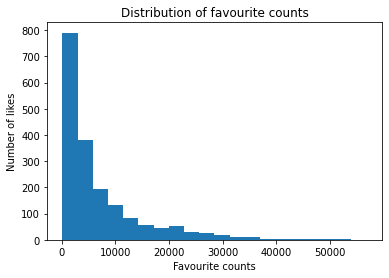

In [75]:
plt.hist(df_hist, bins=20);
plt.xlabel('Favourite counts');
plt.ylabel('Number of likes');
plt.title('Distribution of favourite counts');
plt.savefig('n_likes.png')

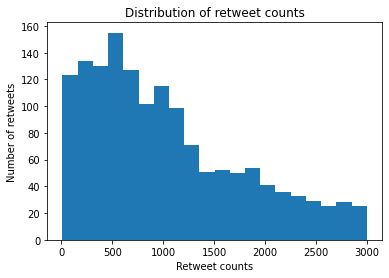

In [76]:
# relationship between rating and favourites
df_hist_2 = df[df['retweet_count'] <= 3000]['retweet_count']
plt.hist(df_hist_2, bins=20);
plt.xlabel('Retweet counts');
plt.ylabel('Number of retweets');
plt.title('Distribution of retweet counts');
plt.savefig('n_retweets.png')

#### Top 10 favourite breeds and their average number of likes - based on first prediction

The top 10 most liked breeds are:
- saluki
- french_bulldog
- afghan_hound
- giant_schnauzer
- black-and-tan_coonhound
- irish_water_spaniel
- tabby
- standard_poodle
- english_springer
- leonberger


In [77]:
# top 10 most liked dog breeds and their average favourite counts 
favourite_by_p1 = df.groupby(['p1'])[['favourite_count']].mean()
top_by_p1 = favourite_by_p1.sort_values("favourite_count", ascending = False)
top_list = top_by_p1.index
top_by_p1.head()
top_10 = top_list[0:10]

In [78]:
print(top_10)

Index(['saluki', 'french_bulldog', 'afghan_hound', 'giant_schnauzer',
       'black-and-tan_coonhound', 'irish_water_spaniel', 'tabby',
       'standard_poodle', 'english_springer', 'leonberg'],
      dtype='object', name='p1')


#### No significant difference in ratings among different stage of dogs

Doggos on average has 1.15 in rating, floofers have 1.2, puppers 1.05 and puppos 1.2. 

In [79]:
likes_by_stage = df.groupby(['stage'])['rating'].mean()

In [80]:
likes_by_stage

stage
                  1.153457
doggo             1.181034
doggo, floofer    1.100000
doggo, pupper     1.100000
doggo, puppo           NaN
floofer           1.200000
pupper            1.058301
puppo             1.194737
Name: rating, dtype: float64